# Bitcoin Price Analysis

Here, my objective is to analyse the bitcoin daily price database obtained from: https://www.investing.com/crypto/bitcoin/historical-data

Initially, the daily timeframe will be the only one taken into account. In the future, I intend to analyse other timeframes like weekly or monthly data.

### 1- Pre-processing with PySpark

1.1- Creating session and reading data

In [36]:
# Importing pyspark and creating a new session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("btc") \
    .getOrCreate()
    

In [37]:
csv_file_path = "Databases/BTC/btc_daily.csv"
data = spark.read.csv(csv_file_path, header=True)
data

DataFrame[Date: string, Price: string, Open: string, High: string, Low: string, Vol.: string, Change %: string]

In [38]:
data.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Vol.: string (nullable = true)
 |-- Change %: string (nullable = true)



In [39]:
data.show()

+----------+--------+--------+--------+--------+-------+--------+
|      Date|   Price|    Open|    High|     Low|   Vol.|Change %|
+----------+--------+--------+--------+--------+-------+--------+
|05/21/2024|70,139.9|71,430.5|71,872.0|69,181.7|108.56K|  -1.80%|
|05/20/2024|71,422.7|66,278.3|71,482.8|66,076.5|112.66K|   7.76%|
|05/19/2024|66,279.1|66,919.0|67,662.5|65,937.3| 36.19K|  -0.95%|
|05/18/2024|66,917.5|67,036.6|67,361.4|66,636.1| 29.68K|  -0.18%|
|05/17/2024|67,036.8|65,231.1|67,420.7|65,121.7| 63.09K|   2.77%|
|05/16/2024|65,231.0|66,219.6|66,643.9|64,623.3| 72.55K|  -1.50%|
|05/15/2024|66,225.1|61,569.4|66,417.1|61,357.5|106.05K|   7.56%|
|05/14/2024|61,569.4|62,936.8|63,102.6|61,156.9| 68.84K|  -2.17%|
|05/13/2024|62,937.2|61,480.5|63,443.2|60,779.0| 70.55K|   2.37%|
|05/12/2024|61,480.0|60,826.6|61,847.7|60,647.1| 27.40K|   1.07%|
|05/11/2024|60,826.6|60,796.8|61,487.5|60,499.3| 27.50K|   0.05%|
|05/10/2024|60,796.9|63,074.3|63,454.3|60,251.8| 79.33K|  -3.61%|
|05/09/202

1.2- Converting columns to their respective types

In [40]:
# importing datatypes that will be used with this database
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import to_date

In [41]:
data = data.withColumnRenamed('Vol.','Vol')
data = data.withColumnRenamed('Change %','Change')

In [42]:
column_names = data.columns
column_names.remove('Date')
column_names

['Price', 'Open', 'High', 'Low', 'Vol', 'Change']

In [43]:
# Removing symbols from 'Vol' and 'Change'
symbols_to_remove = ['K', '%']

for col_name in column_names:
    for symbol in symbols_to_remove:
        data = data.withColumn(col_name, regexp_replace(col(col_name), symbol, ""))

# Convert columns to DoubleType
for col_name in column_names:
    data = data.withColumn(col_name, regexp_replace(col(col_name), ",", ""))
    data = data.withColumn(col_name, col(col_name).cast(DoubleType()))

# Convert "Date" column to DateType
data = data.withColumn("Date", to_date(data["Date"], "MM/dd/yyyy"))

In [44]:
data.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Price: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Vol: double (nullable = true)
 |-- Change: double (nullable = true)



In [45]:
data = data.orderBy(data['Date'])
data.show()

+----------+-------+-------+-------+-------+------+------+
|      Date|  Price|   Open|   High|    Low|   Vol|Change|
+----------+-------+-------+-------+-------+------+------+
|2024-04-21|64940.2|64942.1|65680.6|64267.5| 42.02| -0.03|
|2024-04-22|66829.3|64940.1|67208.0|64527.5|  72.3|  2.91|
|2024-04-23|66415.0|66829.5|67180.0|65848.3| 52.42| -0.62|
|2024-04-24|64285.7|66414.9|67060.5|63606.9| 77.83| -3.21|
|2024-04-25|64497.1|64287.1|65247.5|62889.2| 80.77|  0.33|
|2024-04-26|63766.4|64497.1|64771.3|63354.9|  61.6| -1.13|
|2024-04-27|63456.8|63765.8|63916.7|62507.7| 45.34| -0.49|
|2024-04-28|63109.7|63457.9|64346.1|62827.8| 36.65| -0.55|
|2024-04-29|63860.1|63113.7|64193.1|61837.2| 67.26|  1.19|
|2024-04-30|60666.6|63852.4|64700.2|59228.7|121.04|  -5.0|
|2024-05-01|58331.2|60665.0|60827.5|56643.5|171.55| -3.85|
|2024-05-02|59121.3|58334.9|59548.0|56989.8| 98.06|  1.35|
|2024-05-03|62877.5|59104.3|63298.4|58830.8|100.46|  6.35|
|2024-05-04|63888.3|62887.1|64466.0|62599.1| 53.03|  1.6

### 2- Analysing data

2.1- Ploting a 2024 price chart

In [46]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd

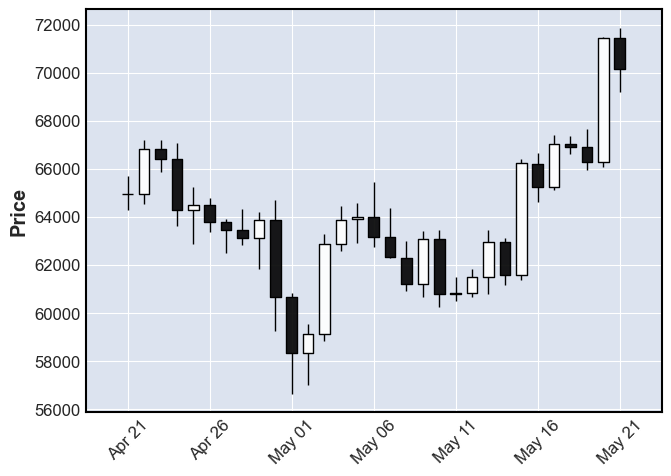

In [47]:
# Filtering current year data
current_year_data = data.where(data['Date'] > '2024-01-01')

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = current_year_data.toPandas()
pandas_df.rename(columns={'Price':'Close'}, inplace=True)
pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])
pandas_df.set_index('Date', inplace=True)
pandas_df.columns
mpf.plot(pandas_df, type='candle')